In [51]:
import numpy as np
import pandas as pd
pd.set_option('display.max_row',100)
pd.set_option('display.float_format','{:20,.2f}'.format)
pd.set_option('display.max_columns',200)
from itertools import product
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline
from xgboost import XGBRegressor
from xgboost import plot_importance
def plot_features(booster,figsize):
    fig,ax = plt.subplot(1,1,figsize = figsize)
    return plot_importance(booster = booster,ax = ax)
from sklearn.feature_extraction.text import TfidfVectorizer

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [29]:
import time
import sys
import gc
import pickle
sys.version_info
# https://github.com/dlarionov/1c/blob/master/features.ipynb

sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)

In [30]:
items = pd.read_csv('./all/items.csv')
shops = pd.read_csv('./all/shops.csv')
cats = pd.read_csv('./all/item_categories.csv')
train = pd.read_csv('./all/sales_train.csv.gz')
test = pd.read_csv('./all/test.csv.gz').set_index('ID')
os.listdir("./all")

['to_win_kaggle_itemprice.csv',
 'test.csv.gz',
 'sample_submission.csv.gz',
 'shops.csv',
 'sales_train.csv.gz',
 'to_win_kaggle.csv',
 'item_categories.csv',
 '.gitignore',
 'items.csv']

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,"2,935,849.00","2,935,849.00","2,935,849.00","2,935,849.00","2,935,849.00"
mean,14.57,33.00,"10,197.23",890.85,1.24
std,9.42,16.23,"6,324.30","1,729.80",2.62
min,0.00,0.00,0.00,-1.00,-22.00
25%,7.00,22.00,"4,476.00",249.00,1.00
50%,14.00,31.00,"9,343.00",399.00,1.00
75%,23.00,47.00,"15,684.00",999.00,1.00
max,33.00,59.00,"22,169.00","307,980.00","2,169.00"


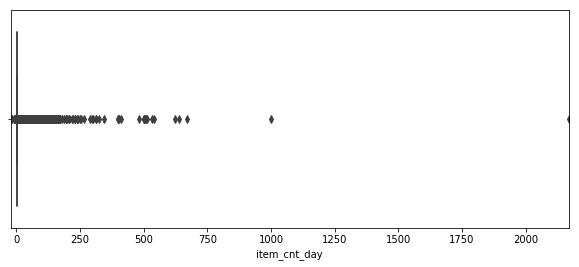

In [31]:
plt.figure(figsize = (10,4))
plt.xlim(train.item_cnt_day.min(),train.item_cnt_day.max())
sns.boxplot(x = train.item_cnt_day)
train.describe()

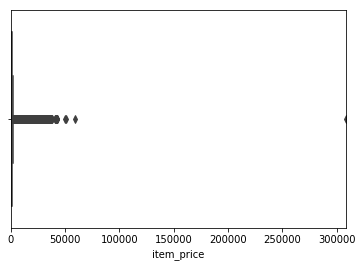

In [32]:
plt.xlim(train.item_price.min(),train.item_price.max())
sns.boxplot(x = train.item_price)

In [33]:
train = train[train.item_price < 100000]

In [34]:
train = train[train.item_cnt_day < 1001]

In [35]:
train[train.item_price < 0].head(20)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.00,1.00


In [36]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [37]:
# train.loc[train.item_cnt_day < 0,'item_cnt_day'] = 0 

In [39]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

In [44]:
cats['split'] =  cats['item_category_name'].str.split('-')
cats['type']  = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

In [47]:
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code','subtype_code']]


In [67]:
tfidf = pd.DataFrame(TfidfVectorizer(max_features = 12).fit_transform(items['item_name']).toarray(),dtype = 'float16')

In [68]:
tfidf.columns = ['tfidf' + str(id + 1) for id in range(12)]
tfidf.index.names  = ['item_id']
tfidf.reset_index(inplace = True)
items.drop(['item_name'],axis = 1,inplace = True)

In [69]:
tfidf.head()

,item_id,tfidf1,tfidf2,tfidf3,tfidf4,tfidf5,tfidf6,tfidf7,tfidf8,tfidf9,tfidf10,tfidf11,tfidf12
0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.57,0.00,0.52,0.00,0.00,0.63
2,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [73]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))),len(list(set(test.item_id))),len(test)

(363, 5100, 214200)

In [74]:
%time



CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
